In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from skimage.feature import local_binary_pattern
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
from skimage.filters import median


In [ ]:
from skimage import feature

!pip install scikit-image

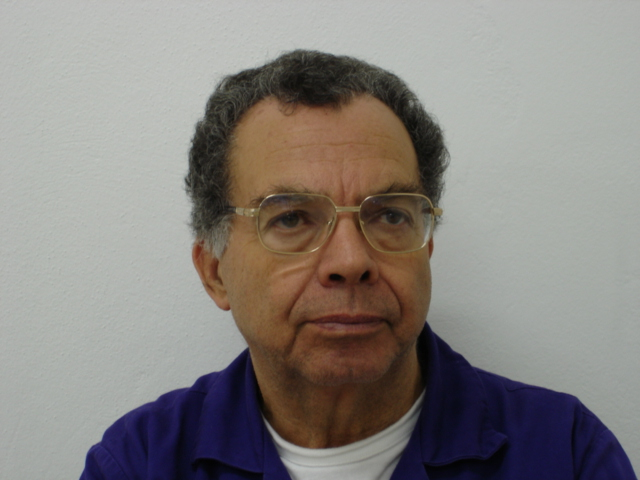

In [ ]:


# Load the image
image = cv2.imread("/content/drive/MyDrive/images/24-06.jpg")


# Convert the image to grayscale
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Display the 8-bit gray level image
cv2_imshow( image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
!pip install MediaPipe

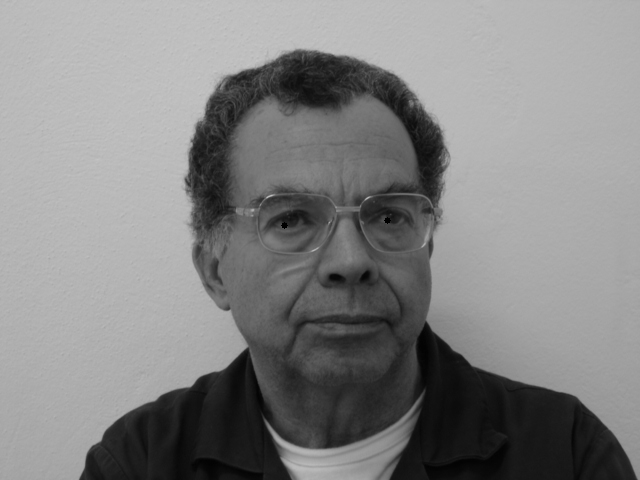

In [ ]:
import cv2
import mediapipe as mp

# Load the MediaPipe FaceMesh solution
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()



# Process the image with FaceMesh
results = face_mesh.process((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# Extract the eye centers
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Define the landmark indices for the left and right eye
        left_eye_landmark_indices = [33, 133, 143, 153, 159, 145]
        right_eye_landmark_indices = [362, 263, 373, 380, 374, 386]

        # Initialize the eye center coordinates
        left_eye_center = [0, 0]
        right_eye_center = [0, 0]

        # Extract the eye center coordinates
        for index in left_eye_landmark_indices:
            landmark = face_landmarks.landmark[index]
            x = int(landmark.x * img.shape[1])
            y = int(landmark.y * img.shape[0])
            left_eye_center[0] += x
            left_eye_center[1] += y

        for index in right_eye_landmark_indices:
            landmark = face_landmarks.landmark[index]
            x = int(landmark.x * img.shape[1])
            y = int(landmark.y * img.shape[0])
            right_eye_center[0] += x
            right_eye_center[1] += y

        # Calculate the average eye center coordinates
        left_eye_center[0] //= len(left_eye_landmark_indices)
        left_eye_center[1] //= len(left_eye_landmark_indices)
        right_eye_center[0] //= len(right_eye_landmark_indices)
        right_eye_center[1] //= len(right_eye_landmark_indices)


        # Display the eye centers
        cv2.circle(img, tuple(left_eye_center), 3, (0, 0, 255), -1)
        cv2.circle(img, tuple(right_eye_center), 3, (0, 0, 255), -1)

# Display the image with eye centers
cv2_imshow(img)


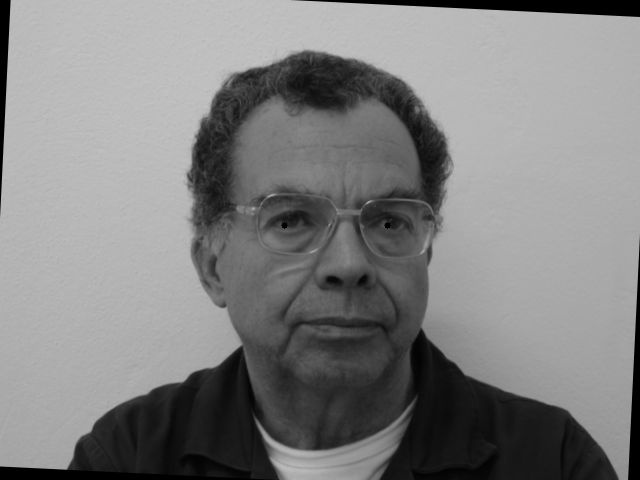

In [ ]:

import math

# Load the facial image


# Eye centers coordinates
eye_center1 = ( left_eye_center[0], left_eye_center[1])  # Coordinates of first eye center
eye_center2 = ( right_eye_center[0], right_eye_center[1])  # Coordinates of second eye center

# Calculate the angle of the line linking the eye centers
angle = math.degrees(math.atan2(right_eye_center[1] -  left_eye_center[1],  right_eye_center[0] - left_eye_center[0]))

# Rotate the image
rows, cols = img.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D(eye_center1, angle, 1.0)
rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR)

# Display the rotated image
cv2_imshow( rotated_image)



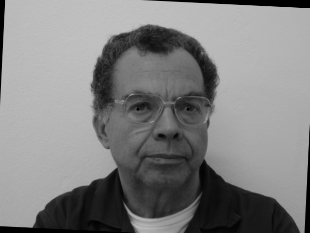

In [ ]:


# Calculate the current distance between the eye centers
current_eye_distance = math.sqrt((right_eye_center[1] -  left_eye_center[1]) ** 2 + (right_eye_center[0] - left_eye_center[0]) ** 2)
# Define the desired eye distance (e.g., 50 pixels)
desired_eye_distance = 50

# Calculate the scaling factor
scaling_factor = desired_eye_distance / current_eye_distance

# Scale the image using the scaling factor
scaled_image = cv2.resize(rotated_image, None, fx=scaling_factor, fy=scaling_factor)

# Display the scaled image
cv2_imshow( scaled_image)
cv2.waitKey(0)

cv2.destroyAllWindows()


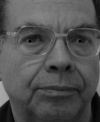

In [ ]:

# Initialize the face mesh model
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Process the image and get the face landmarks
results = face_mesh.process((cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)))

# Check if any face landmarks are detected
if results.multi_face_landmarks:
    # Get the face landmarks for the first face
    face_landmarks = results.multi_face_landmarks[0]

    # Extract the coordinates of the face landmarks
    landmarks = []
    for landmark in face_landmarks.landmark:
        x = int(landmark.x *scaled_image.shape[1])
        y = int(landmark.y * scaled_image.shape[0])
        landmarks.append((x, y))

    # Define the face region based on desired landmarks
    # Add a vertical offset to include the entire forehead
    min_x = min(landmarks, key=lambda p: p[0])[0]
    max_x = max(landmarks, key=lambda p: p[0])[0]
    min_y = min(landmarks, key=lambda p: p[1])[1]
    max_y = max(landmarks, key=lambda p: p[1])[1]

    # Crop the image to the face region
    cropped_image = scaled_image[min_y:max_y, min_x:max_x]

    # Display the cropped image
    cv2_imshow(cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No face landmarks detected in the image.")


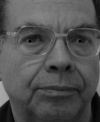

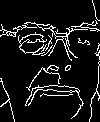

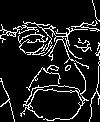

In [ ]:
img_blur = cv2.GaussianBlur(cropped_image, (1, 1), 0)
cv2_imshow(img_blur)
# Apply Canny edge detection with high threshold
edges = cv2.Canny(img_blur, 50, 200)

# Apply Canny edge detection with low threshold
edges2 = cv2.Canny(img_blur, 20, 220)

# Smooth the edges
#edges3 = cv2.dilate(edges, None, iterations=1)
#dges3 = cv2.erode(edges3, None, iterations=1)
#edges4 = cv2.dilate(edges2, None, iterations=1)
#edges4 = cv2.erode(edges4, None, iterations=1)

# Save the final image
cv2_imshow(edges)
cv2_imshow(edges2)
#cv2_imshow(edges3)
#cv2_imshow(edges4)

In [ ]:
otsu_thresh, _ = cv2.threshold(img_blur, 0, 255, cv2.THRESH_OTSU)
triangle_thresh, _ = cv2.threshold(img_blur, 0, 255, cv2.THRESH_TRIANGLE)
manual_thresh = np.median(img_blur)

def get_range(threshold, sigma=0.33):
    return (1-sigma) * threshold, (1+sigma) * threshold

otsu_thresh = get_range(otsu_thresh)
triangle_thresh = get_range(triangle_thresh)
manual_thresh = get_range(manual_thresh)

print(f"Otsu's Threshold: {otsu_thresh} \nTriangle Threshold: {triangle_thresh} \nManual Threshold: {manual_thresh}")


Otsu's Threshold: (52.92999999999999, 105.07000000000001) 
Triangle Threshold: (58.959999999999994, 117.04) 
Manual Threshold: (55.60999999999999, 110.39)


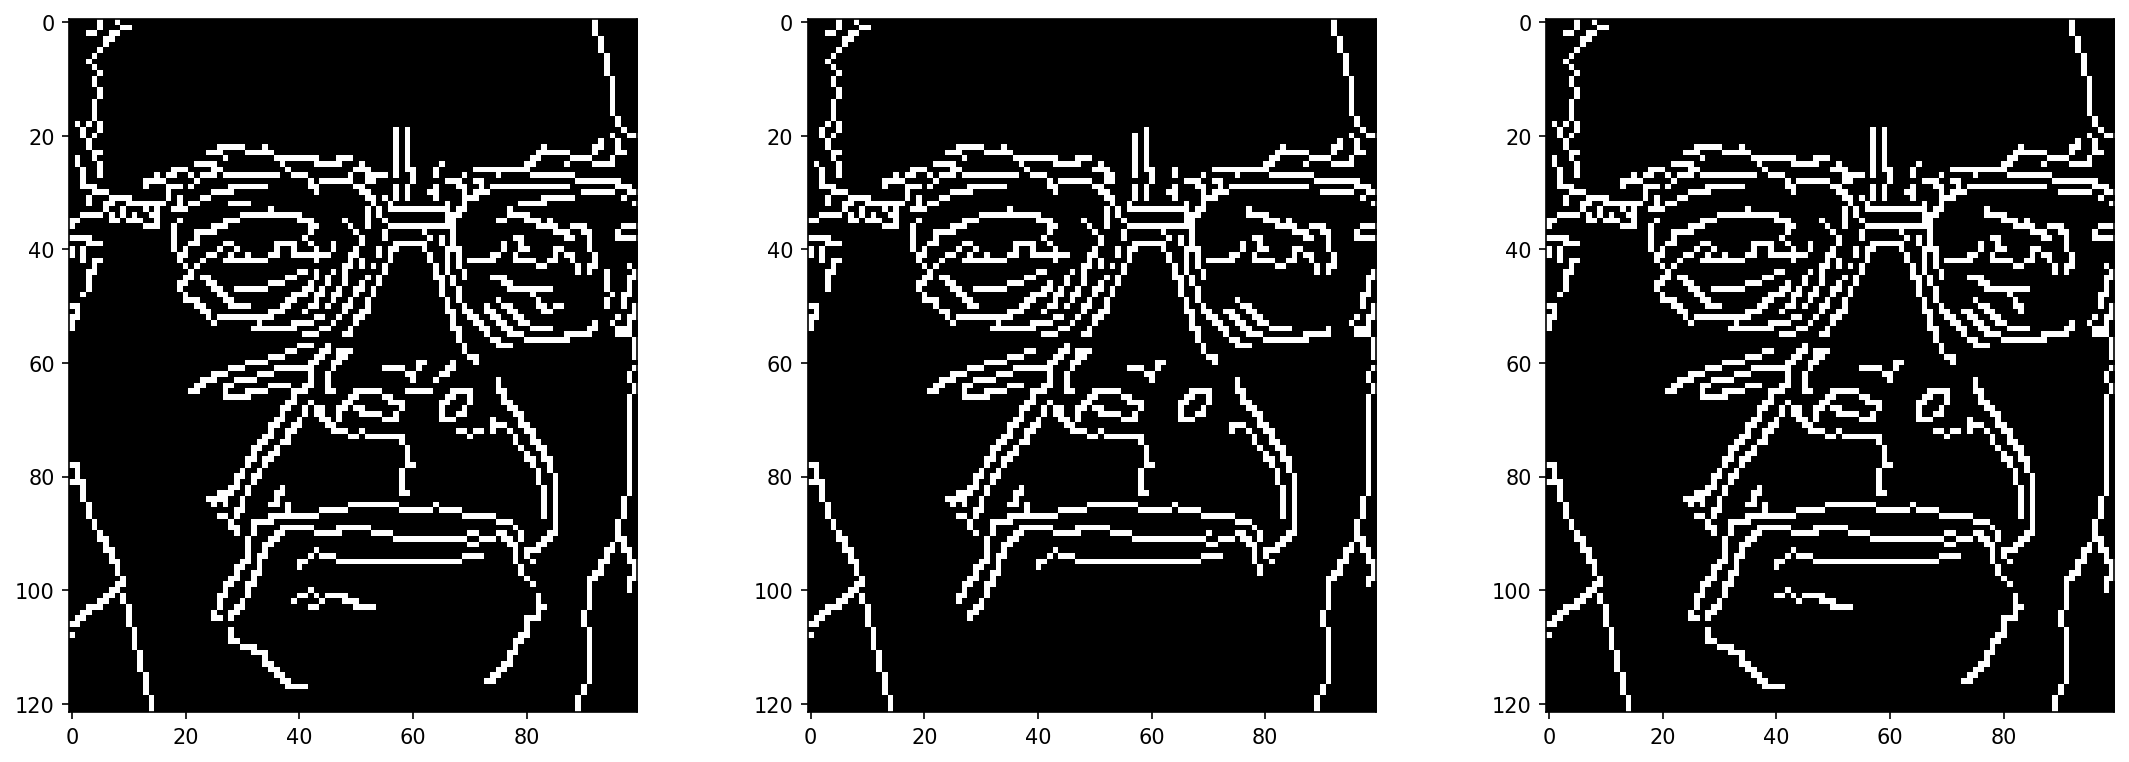

In [ ]:
edge_otsu = cv2.Canny(img_blur, *otsu_thresh)
edge_triangle = cv2.Canny(img_blur, *triangle_thresh)
edge_manual = cv2.Canny(img_blur, *manual_thresh)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
ax[0].imshow(edge_otsu, cmap='gray')
ax[1].imshow(edge_triangle, cmap='gray')
ax[2].imshow(edge_manual, cmap='gray')

In [ ]:
a=edge_otsu[0:23, 10:90]
cv2_imshow(a)

In [ ]:
def canny(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = 5
    blur = cv2.GaussianBlur(gray,(kernel, kernel),0)
    canny = cv2.Canny(gray, 50, 150)
    return canny


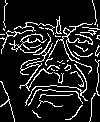

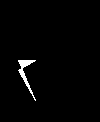

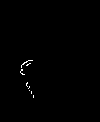

In [ ]:
def canny(img):
    if len(img.shape) > 2 and img.shape[2] > 1:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    kernel = 5
    blur = cv2.GaussianBlur(gray, (kernel, kernel), 0)
    canny = cv2.Canny(blur, 20, 70)
    return canny

def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)

    rectangle = np.array([[
    (18, 60),
    (35, 60),
    (18, 70),(35,100)]], np.int32)

    cv2.fillPoly(mask, rectangle, 255)
    cv2_imshow(mask)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image


lane_canny = canny(cropped_image)
cv2_imshow(lane_canny)
cropped_canny = region_of_interest(lane_canny)
cv2_imshow(cropped_canny)


In [ ]:
import cv2
import mediapipe as mp

def extract_forehead(cropped_image):
    # Load the Mediapipe face detection model
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()



    # Detect faces in the image
    results = face_mesh.process((cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)))

    # Check if any faces are detected
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get the coordinates of the forehead region
            left_brow_x = face_landmarks.landmark[17].x * cropped_image.shape[1]
            right_brow_x = face_landmarks.landmark[26].x * cropped_image.shape[1]
            forehead_y = face_landmarks.landmark[20].y * cropped_image.shape[0]

            # Calculate the width and height of the forehead region
            forehead_width = right_brow_x - left_brow_x
            forehead_height = cropped_image.shape[0] - forehead_y

            # Extract the forehead region from the image
            forehead = cropped_image[int(forehead_y):int(forehead_y + forehead_height),
                             int(left_brow_x):int(left_brow_x + forehead_width)]

            # Return the forehead region
            return forehead





# Extract the forehead region
forehead = extract_forehead(cropped_image)

plt.imshow(forehead)
plt.axis("off")
plt.show()

In [ ]:
import cv2
import mediapipe as mp

def extract_forehead_region(image, landmarks):
    """Extracts the region of forehead from an image using MediaPipe landmarks.

    Args:
        image: The image to extract the region of forehead from.
        landmarks: The landmarks of the face in the image.

    Returns:
        The region of forehead as a NumPy array.
    """

    forehead_landmarks = [
        landmarks.landmark[mp_face_mesh.FACEMESH_FOREHEAD_LEFT_EYEBROW],
        landmarks.landmark[mp_face_mesh.FACEMESH_FOREHEAD_RIGHT_EYEBROW],
        landmarks.landmark[mp_face_mesh.FACEMESH_FOREHEAD_MIDDLE],
    ]

    x_min = min(landmark.x for landmark in forehead_landmarks)
    y_min = min(landmark.y for landmark in forehead_landmarks)
    x_max = max(landmark.x for landmark in forehead_landmarks)
    y_max = max(landmark.y for landmark in forehead_landmarks)

    roi = image[y_min:y_max, x_min:x_max]

    return roi
results = face_mesh.process((cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)))
roi = extract_forehead_region(cropped_image, results.face_landmarks)
cv2_imshow( roi)
cv2.waitKey(0)


In [ ]:
def extract_region_of_interest(image, roi):
    """Extracts the region of interest from an image.

    Args:
        image: The image to extract the region of interest from.
        roi: The region of interest as a list of coordinates.

    Returns:
        The region of interest as a NumPy array.
    """

    mask = np.zeros_like(image)
    cv2.fillPoly(mask, roi, 1)
    roi_image = cv2.bitwise_and(image, mask)

    return roi_image

def extract_aging_signs(image):
    """Extracts the aging signs from an image.

    Args:
        image: The image to extract the aging signs from.

    Returns:
        The aging signs as a list of bounding boxes.
    """

    aging_signs = []

    # Apply a filter to detect edges in the image.
    edges = cv2.Canny(image, 100, 200)

    # Find the contours in the image.
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and extract the bounding boxes.
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aging_signs.append([x, y, w, h])

    return aging_signs


roi = [[100, 100, 200, 200]]
roi_image = extract_region_of_interest(image, roi)
aging_signs = extract_aging_signs(roi_image)

print(aging_signs)

In [ ]:
def extract_lbp(image, P, R):


    lbp = local_binary_pattern(image, P,R)


    return np.array(lbp)

In [ ]:
lbp = extract_lbp( cropped_image, 8, 1)
lpp=extract_lbp(cropped_image, 8, 2)

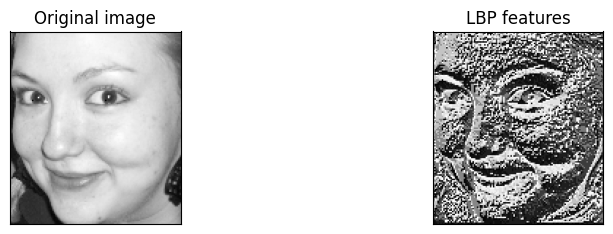

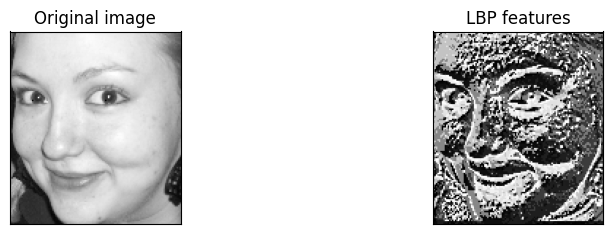

In [ ]:
def show_images(image,lbp):

 fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 2.5))
 axes[0].imshow( image, cmap='gray')
 axes[0].set_title('Original image')
 axes[0].get_xaxis().set_visible(False)
 axes[0].get_yaxis().set_visible(False)

 axes[1].imshow(lbp, cmap='gray')
 axes[1].set_title('LBP features')
 axes[1].get_xaxis().set_visible(False)
 axes[1].get_yaxis().set_visible(False)

show_images(cropped_image, lbp)
show_images(cropped_image, lpp)

In [ ]:
#creating hog features
fd, hog_image = hog((cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)), orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

<ipython-input-37-e6939d402452>:2: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog((cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)), orientations=9, pixels_per_cell=(8, 8),


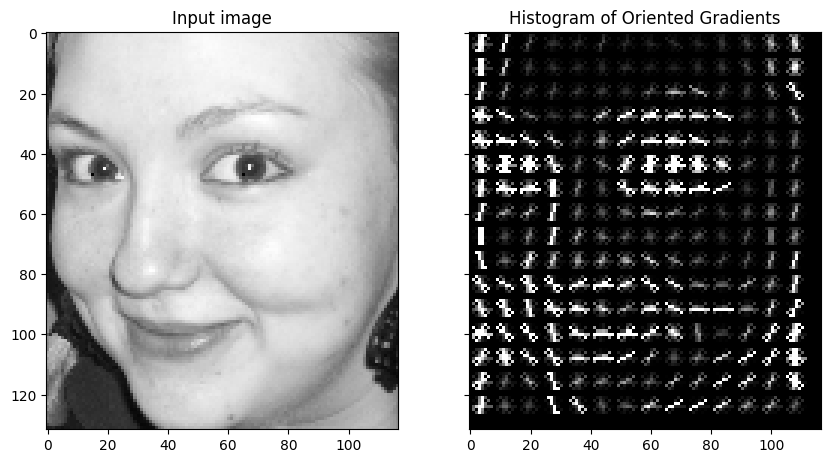

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharex=True, sharey=True)

ax1.imshow(cropped_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
import numpy as np
import skimage.feature as skif

image = np.random.randint(0, 255, (50, 50))
glcm = skif.graycomatrix(image, levels=256, distances=[1], angles=[0])

print(glcm)


In [ ]:

# Load the image
image = cv2.imread("/content/drive/MyDrive/shot.jpg")


# Convert the image to grayscale
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Display the 8-bit gray level image
cv2_imshow( image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def give_median_image(gray_img):
    median_image = median(gray_img, selem=None, out=None)
    return median_image

In [ ]:
median_img = give_median_image(img)
cv2_imshow( median_img)
cv2.waitKey(0)
cv2.destroyAllWindows()